In [12]:
import pandas as pd

df = pd.read_csv('cell2celltrain.csv')
df = df.drop(columns=['CustomerID'])
df.head()

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [13]:
df = pd.get_dummies(df, columns=['ServiceArea','TruckOwner','RVOwner','Homeownership','BuysViaMailOrder',
                           'RespondsToMailOffers','OptOutMailings','NonUSTravel','OwnsComputer',
                           'HasCreditCard','RetentionOffersAccepted','NewCellphoneUser','NotNewCellphoneUser',
                           'IncomeGroup','OwnsMotorcycle','MadeCallToRetentionTeam','CreditRating',
                           'PrizmCode','Occupation','MaritalStatus','ChildrenInHH','HandsetRefurbished',
                           'HandsetWebCapable','HandsetPrice'])

In [14]:
import networkx as nx
import math

def compute_distance(G, node_index_1, node_index_2, cols):
    total_euclidean_dist = 0.0
    for col in cols:
        if col != 'Churn':
            total_euclidean_dist = total_euclidean_dist + \
                                   pow(G.nodes[node_index_1][col] - G.nodes[node_index_2][col], 2)
    return round(math.sqrt(total_euclidean_dist), 2)

def create_graph(df):
    g = nx.Graph()
    cols = df.columns
    rows = len(df)
    for row_index in range(rows):
        g.add_node(row_index)
        for col in cols:
            g.nodes[row_index][col] = df.iloc[row_index][col]
    
    for row_index_1 in range(rows):
        for row_index_2 in range(rows):
            if df.iloc[row_index_1]['Churn'] == df.iloc[row_index_2]['Churn'] and row_index_1 != row_index_2 \
               and not((g.has_edge(row_index_1, row_index_2) or g.has_edge(row_index_2, row_index_1))):
                w = compute_distance(g, row_index_1, row_index_2, cols)
                g.add_edge(row_index_1, row_index_2, weight=w)
    return g

In [15]:
import matplotlib.pyplot as plt

def display_graph(G):
    plt.figure()
    pos = nx.spring_layout(G,scale=4)

    node_labels = nx.get_node_attributes(G,'Churn')
    nx.draw_networkx_labels(G, pos, labels = node_labels)
    nx.draw(G,pos, with_labels=False)
    plt.show() 

In [16]:
filtered_df = df.head(300)

/Users/avnag/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':


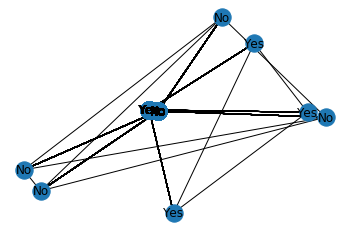

In [17]:
from sklearn.model_selection import train_test_split

df_y = filtered_df['Churn']
train_x, test_x ,train_y, test_y = train_test_split(filtered_df, df_y)
g = create_graph(train_x)
display_graph(g)

In [18]:
train_x = train_x.drop(columns=['Churn'])
test_x = test_x.drop(columns=['Churn'])

In [19]:
import torch 
import numpy as np
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
from pygcn.utils import sparse_mx_to_torch_sparse_tensor

le = preprocessing.LabelEncoder()
le.fit(train_y.values)
train_dataset = TensorDataset(torch.tensor(train_x.values.astype(np.float32)), 
                              torch.tensor(le.transform(train_y.values)))
test_dataset = TensorDataset(torch.tensor(test_x.values.astype(np.float32)), 
                             torch.tensor(le.transform(test_y.values)))                                        
train_dataset_loader = DataLoader(dataset = train_dataset, batch_size=len(train_dataset))
test_dataset_loader = DataLoader(dataset = test_dataset, batch_size=len(test_dataset))

In [20]:
from torch.optim import Adam
import torch.nn as nn
from pygcn.models import GCN
import torch.nn.functional as F

gcn_model = GCN(nfeat=len(train_x.columns),
                nhid=16,
                nclass=2,
                dropout=0.5)
optimizer = Adam(gcn_model.parameters())

In [21]:
import torch.nn.functional as F

adj = sparse_mx_to_torch_sparse_tensor(nx.adjacency_matrix(g))
for epoch in range(100):
    gcn_model.train()
    for i, (features, labels) in enumerate(train_dataset_loader):
        optimizer.zero_grad()
        outputs = gcn_model(features, adj)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

In [22]:
gcn_model.eval()
for i, (features, labels) in enumerate(train_dataset_loader):
        output = gcn_model(features, adj)